# Final LDA Model

In [49]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
# import pyLDAvis.gensim  # Author: don't skip this
# pyLDAvis.gensim.prepare

# I think i need another one:
import pyLDAvis.gensim_models
import pyLDAvis.gensim_models as gensimvis

# Plots
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [50]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('dutch')
stop_words.extend(['tenlastelegging\\n\\n\\naan', '\\n\\n\\n\\n\\n\\n', '\\n\\n\\n\\n\\n', '\\n\\n', 'een', 'naan', 'nde', 'nhij', '\\n'])

# Data Test

In [51]:
# Data
df = pd.read_csv('/Users/dj/Python - UvA/DSP/data/DataSample_DSP_0712.csv', index_col=1) 
df = df[df['re_tll'] != '[]'][['re_tll']] #re_bewijs
# data = [i for i in df['re_tll']]

# Data Final

In [52]:
df = pd.read_csv('/Users/dj/Python - UvA/DSP/data/dataset_10012022.csv', index_col=1) 

In [53]:
df.head()

,Unnamed: 0,ecli,subject,spatial,case_nr,date,bewijs,tll
filename,,,,,,,,
ECLI_NL_GHARL_2021_1844.xml,0,ECLI:NL:GHARL:2021:1844,Strafrecht,Leeuwarden,Wahv 200.253.228,2021-02-25,[],[]
ECLI_NL_HR_2021_218.xml,1,ECLI:NL:HR:2021:218,Strafrecht,NaN,19/04191,2021-02-16,[],[]
ECLI_NL_GHARL_2020_149.xml,2,ECLI:NL:GHARL:2020:149,Strafrecht,NaN,21-005398-18,2020-01-06,[],[]
ECLI_NL_PHR_2019_165.xml,3,ECLI:NL:PHR:2019:165,Strafrecht,NaN,16/06093,2019-01-08,[],[]
ECLI_NL_RBGEL_2018_50.xml,4,ECLI:NL:RBGEL:2018:50,Strafrecht,Arnhem,05/881874-16,2018-01-08,[],"[""[' tenlastelegging\\n\\n\\naan verdachte is ..."


In [54]:
df_be = df[df['bewijs'] != '[]'] #bewijs
df_te = df[df['tll'] != '[]'] #tenlastelegging

In [55]:
df_be.head()

,Unnamed: 0,ecli,subject,spatial,case_nr,date,bewijs,tll
filename,,,,,,,,
ECLI_NL_GHSHE_2021_1801.xml,9,ECLI:NL:GHSHE:2021:1801,Strafrecht,'s-Hertogenbosch,20-003457-18,2021-02-10,['[\'\\n\\n\\n\\n\\n\\nbewijsmiddelen\\n\\n\\n...,[]
ECLI_NL_GHARL_2020_820.xml,10,ECLI:NL:GHARL:2020:820,Strafrecht,Leeuwarden,21-001899-19,2020-01-30,"[""['\\n\\n\\n\\n\\n\\nbewijsmiddelen, feiten e...","[""[' tenlastelegging\\n\\n\\naan verdachte is ..."
ECLI_NL_RBROT_2021_2966.xml,24,ECLI:NL:RBROT:2021:2966,Strafrecht,Rotterdam,10.295806.20,2021-02-09,['[\'\\n\\nbewijswaardering\\n\\n\\n4.1.1.\\n\...,[]
ECLI_NL_RBMNE_2019_6577.xml,28,ECLI:NL:RBMNE:2019:6577,Strafrecht,Utrecht,16/018445-18,2019-01-18,"[""['\\n\\n\\nbewijsmiddelen\\n\\n\\n\\n ...","[""['\\n\\n2tenlastelegging\\n\\n\\nde tenlaste..."
ECLI_NL_GHAMS_2018_185.xml,32,ECLI:NL:GHAMS:2018:185,Strafrecht,Amsterdam,23-002003-17,2018-01-24,"[""['\\n\\n\\n\\n\\n\\nbewijsverweren\\n\\n\\n\...",[]


In [56]:
df['bete'] = df['bewijs'] + df['tll'] 
df = df[df['bete'] != '[][]']
df = df.drop(labels=['bewijs', 'tll'], axis=1)

In [57]:
df.head()

,Unnamed: 0,ecli,subject,spatial,case_nr,date,bete
filename,,,,,,,
ECLI_NL_RBGEL_2018_50.xml,4,ECLI:NL:RBGEL:2018:50,Strafrecht,Arnhem,05/881874-16,2018-01-08,"[][""[' tenlastelegging\\n\\n\\naan verdachte i..."
ECLI_NL_GHAMS_2019_194.xml,5,ECLI:NL:GHAMS:2019:194,Strafrecht,Amsterdam,23-005312-13,2019-01-25,"[][""['\\ntenlastelegging\\n\\n\\naan de verdac..."
ECLI_NL_RBOVE_2021_606.xml,8,ECLI:NL:RBOVE:2021:606,Strafrecht,Almelo,08/760218-17 (P),2021-02-10,"[][""[' tenlastelegging\\n\\n\\nde verdenking k..."
ECLI_NL_GHSHE_2021_1801.xml,9,ECLI:NL:GHSHE:2021:1801,Strafrecht,'s-Hertogenbosch,20-003457-18,2021-02-10,['[\'\\n\\n\\n\\n\\n\\nbewijsmiddelen\\n\\n\\n...
ECLI_NL_GHARL_2020_820.xml,10,ECLI:NL:GHARL:2020:820,Strafrecht,Leeuwarden,21-001899-19,2020-01-30,"[""['\\n\\n\\n\\n\\n\\nbewijsmiddelen, feiten e..."


# Tokenize 

In [58]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df['bete']))

print(data_words[:1])

[['tenlastelegging', 'naan', 'verdachte', 'is', 'ten', 'laste', 'gelegd', 'dat', 'nhij', 'in', 'of', 'omstreeks', 'de', 'periode', 'van', 'november', 'tot', 'en', 'met', 'november', 'in', 'arnhem', 'en', 'of', 'in', 'nederland', 'en', 'of', 'in', 'duitsland', 'en', 'of', 'in', 'oostenrijk', 'en', 'of', 'in', 'hongarije', 'opzettelijk', 'een', 'of', 'meer', 'minderjarige', 'te', 'weten', 'naam', 'geboren', 'op', 'geboortedatum', 'in', 'geboorteplaats', 'en', 'of', 'naam', 'geboren', 'op', 'geboortedatum', 'in', 'geboorteplaats', 'heeft', 'onttrokken', 'aan', 'het', 'wettig', 'over', 'hen', 'haar', 'gesteld', 'gezag', 'en', 'of', 'aan', 'het', 'opzicht', 'van', 'degene', 'die', 'dit', 'desbevoegd', 'over', 'hen', 'haar', 'uitoefende', 'terwijl', 'die', 'minderjarige', 'beneden', 'de', 'twaalf', 'jaren', 'oud', 'was', 'waren', 'en', 'of', 'terwijl', 'list', 'was', 'gebezigd', 'bestaande', 'uit', 'het', 'door', 'verdachte', 'aan', 'de', 'school', 'van', 'de', 'minderjarig', 'in', 'strijd',

# Creating Bigram and Trigram Models

In [59]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['tenlastelegging', 'naan', 'verdachte', 'is', 'ten', 'laste', 'gelegd', 'dat', 'nhij', 'in', 'of', 'omstreeks', 'de', 'periode', 'van', 'november', 'tot', 'en', 'met', 'november', 'in', 'arnhem', 'en', 'of', 'in', 'nederland', 'en', 'of', 'in', 'duitsland', 'en', 'of', 'in', 'oostenrijk', 'en', 'of', 'in', 'hongarije', 'opzettelijk', 'een', 'of', 'meer', 'minderjarige', 'te', 'weten', 'naam', 'geboren', 'op', 'geboortedatum', 'in', 'geboorteplaats', 'en', 'of', 'naam', 'geboren', 'op', 'geboortedatum', 'in', 'geboorteplaats', 'heeft', 'onttrokken', 'aan', 'het', 'wettig', 'over', 'hen', 'haar', 'gesteld', 'gezag', 'en', 'of', 'aan', 'het', 'opzicht', 'van', 'degene', 'die', 'dit', 'desbevoegd', 'over', 'hen', 'haar', 'uitoefende', 'terwijl', 'die', 'minderjarige', 'beneden', 'de', 'twaalf_jaren', 'oud', 'was', 'waren', 'en', 'of', 'terwijl', 'list', 'was', 'gebezigd', 'bestaande', 'uit', 'het', 'door', 'verdachte', 'aan', 'de', 'school', 'van', 'de', 'minderjarig', 'in', 'strijd', 'me

# Remove Stopwords, Make Bigrams and Lemmatize

In [60]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [61]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
# nlp = spacy.load('nl', disable=['parser', 'ner'])

nlp = spacy.load("nl_core_news_sm")

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['tenlastelegging', 'verdenken', 'last', 'leggen', 'periode', 'oostenrijk', 'opzettelijk', 'minderjarig', 'weten', 'naam', 'baren', 'geboortedatum', 'geboorteplaats', 'naam', 'baren', 'geboortedatum', 'geboorteplaats', 'onttrekken', 'wettig', 'stellen', 'gezag', 'opzicht', 'desbevoegd', 'uitoefenen', 'minderjarig', 'twaalf_jar', 'oud', 'list', 'bezigen', 'bestaan', 'verdenken', 'school', 'minderjarig', 'strijd', 'waarheid', 'mededeel', 'minderjarig', 'afspraak', 'tandarts', 'minderjarig', 'daarvoor', 'vroeger', 'halen', 'school', 'verdenken', 'huis', 'lok', 'verdachte', 'echtgenote', 'genaamd', 'naam', 'maken', 'afspraak', 'woonboulevard', 'beweerdelijk', 'gaan', 'shopp', 'verdenken', 'paspoort', 'kleding', 'toiletartikel', 'minderjarig', 'woning', 'toverweging', 'aanzien', 'bewijs', 'feit', 'nop', 'grond', 'bewijsmiddel', 'volgen', 'ver', 'discussie', 'staan', 'vaststellen', 'naangeefst', 'naam', 'verdenken', 'trouwen', 'samen', 'kind', 'naam', 'baren', 'geboortedatum', 'geboorteplaa

#  Create the Dictionary and Corpus needed for Topic Modeling

In [62]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# corpus1 = [str(item) for item in corpus]

# View
print(corpus[:1])

[[(0, 4), (1, 1), (2, 1), (3, 1), (4, 4), (5, 1), (6, 1), (7, 4), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 5), (33, 4), (34, 4), (35, 1), (36, 2), (37, 3), (38, 1), (39, 4), (40, 1), (41, 1), (42, 1), (43, 2), (44, 10), (45, 2), (46, 1), (47, 3), (48, 3), (49, 3), (50, 3), (51, 2), (52, 1), (53, 2), (54, 1), (55, 1), (56, 1), (57, 1), (58, 6), (59, 1), (60, 10), (61, 1), (62, 1), (63, 1), (64, 4), (65, 1), (66, 1), (67, 1), (68, 3), (69, 2), (70, 2), (71, 2), (72, 2), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 2), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 2), (86, 4), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 3), (94, 1), (95, 3), (96, 1), (97, 4), (98, 1), (99, 1), (100, 1), (101, 1), (102, 2), (103, 1), (104, 4), (105, 1), (106, 1), (107, 1), (108, 4), (109, 1), (110, 

In [63]:
# Id word
id2word[0]

'aangeefster'

# Building the Topic Model

In [64]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# View the topics in LDA model

In [65]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.052*"verdenken" + 0.019*"medeverdacht" + 0.015*"rechtbank" + 0.014*"naam" '
  '+ 0.010*"uur" + 0.008*"aantreffen" + 0.008*"verklaren" + 0.007*"gaan" + '
  '0.007*"zeggen" + 0.007*"kenteken"'),
 (1,
  '0.071*"slachtoffer" + 0.033*"verdenken" + 0.025*"naam" + 0.023*"althans" + '
  '0.020*"ander" + 0.012*"geval" + 0.011*"geweld" + 0.011*"weten" + '
  '0.008*"goed" + 0.008*"vereniging"'),
 (2,
  '0.037*"verdenken" + 0.030*"slachtoffer" + 0.021*"zien" + '
  '0.012*"verbalisant" + 0.011*"man" + 0.009*"komen" + 0.009*"verklaren" + '
  '0.009*"bijnaam" + 0.008*"auto" + 0.008*"rechtbank"'),
 (3,
  '0.051*"verdenken" + 0.029*"hof" + 0.028*"benadelen" + 0.014*"verklaren" + '
  '0.012*"feit" + 0.012*"aangeefster" + 0.011*"bewijzen" + 0.009*"verklaring" '
  '+ 0.008*"omstandigheid" + 0.008*"oordeel"'),
 (4,
  '0.027*"verdenken" + 0.023*"naam" + 0.017*"bedrijf" + 0.017*"althans" + '
  '0.015*"ander" + 0.012*"telkens" + 0.010*"periode" + 0.009*"geval" + '
  '0.009*"weten" + 0.008*"geld"')]


# Compute Model Perplexity and Coherence Score

In [66]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.31093644701238

Coherence Score:  0.46799674466118263


# Visualize the topics-keywords

In [67]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word, R = 10)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.057999  0.029081       1        1  26.778486
2      0.134834 -0.132281       2        1  22.290005
1     -0.137710 -0.166665       3        1  19.755071
3      0.148864  0.136733       4        1  16.939939
4     -0.203986  0.133131       5        1  14.236499, topic_info=             Term          Freq         Total Category  logprob  loglift
694   slachtoffer  19242.000000  19242.000000  Default  10.0000  10.0000
271           hof   4618.000000   4618.000000  Default   9.0000   9.0000
406     benadelen   5454.000000   5454.000000  Default   8.0000   8.0000
60           naam  11312.000000  11312.000000  Default   7.0000   7.0000
173       althans   7009.000000   7009.000000  Default   6.0000   6.0000
...           ...           ...           ...      ...      ...      ...
135         ander   1974.978583   7189.796019   Topic5  -4.2111   0.6573
113     verdenken   3546.457688  38471.208316   Topic5  -3.6258  -0.4346
140         geval   1241.747496   4137.064491   Topic5  -4.6752   0.7459
1426         geld   1108.209142   2988.619767   Topic5  -4.7890   0.9573
127         weten   1181.914624   5183.174146   Topic5  -4.7246   0.4711

[152 rows x 6 columns], token_table=      Topic      Freq                Term
term                                     
0         3  0.352922         aangeefster
0         4  0.646610         aangeefster
363       1  0.011487  aanmerkelijke_kans
363       2  0.984071  aanmerkelijke_kans
1305      3  0.995317            aanraken
...     ...       ...                 ...
802       2  0.742908                zien
802       3  0.026868                zien
802       4  0.077414                zien
802       5  0.001008                zien
3397      2  0.995720    zover_inhoudenen

[319 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4, 5])

# How to find the optimal number fo topics for LDA?

In [68]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [69]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=15, step=1)  # 2,40,6

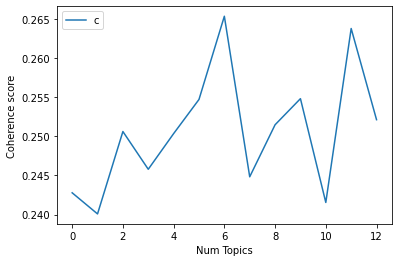

In [70]:
# Show graph

plt.plot(coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# TF-IDF

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_distances

In [72]:
sample = list(df['bete'])

# Approach 2

In [73]:
dat_lem_untok = [" ".join(x) for x in data_lemmatized]
tfidf_vectorizer = TfidfVectorizer(input=dat_lem_untok, stop_words=stop_words)

In [74]:
tfidf_vector = tfidf_vectorizer.fit_transform(dat_lem_untok)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['tenlastelegging'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [84]:
tfidf_df = pd.DataFrame(tfidf_vector.toarray(), columns=tfidf_vectorizer.get_feature_names())

In [86]:
tfidf_df.stack().reset_index()

,level_0,level_1,0
0,0,aa,0.0
1,0,aa_flesje,0.0
2,0,aaan,0.0
3,0,aaei,0.0
4,0,aafe,0.0
...,...,...,...
33782307,1431,zwitsers,0.0
33782308,1431,zwoll,0.0
33782309,1431,zwolle,0.0
33782310,1431,zygoma,0.0


In [77]:
tfidf_df = tfidf_df.stack().reset_index()
tfidf_df = tfidf_df.rename(columns={0:'tfidf', 'level_0': 'document','level_1': 'term', 'level_2': 'term'})
tfidf_df.sort_values(by=['document','tfidf'], ascending=[True,False]).groupby(['document']).head(10)
top_tfidf = tfidf_df.sort_values(by=['document','tfidf'], ascending=[True,False]).groupby(['document']).head(10)

In [78]:
top_tfidf[top_tfidf['term'].str.contains('hof')]

,document,term,tfidf
78393,3,hof,0.528631
101984,4,hof,0.198150
125575,5,hof,0.156488
219939,9,hof,0.273775
337894,14,hof,0.205089
...,...,...,...
32681155,1385,hof,0.231162
32987838,1398,hof,0.311561
33011429,1399,hof,0.188011
33554022,1422,hof,0.279144


In [79]:
# Doesn't work due to the length constraint of a document (max. 5000)

import altair as alt
import numpy as np

# Terms in this list will get a red dot in the visualization
term_list = ['benadelen', 'kasboek', 'hof']

# adding a little randomness to break ties in term ranking
top_tfidf_plusRand = top_tfidf.copy()
top_tfidf_plusRand = top_tfidf_plusRand.iloc[:500,]
top_tfidf_plusRand['tfidf'] = top_tfidf_plusRand['tfidf'] + np.random.rand(top_tfidf_plusRand.shape[0])*0.0001

# base for all visualizations, with rank calculation
base = alt.Chart(top_tfidf_plusRand).encode(
    x = 'rank:O',
    y = 'document:N'
).transform_window(
    rank = "rank()",
    sort = [alt.SortField("tfidf", order="descending")],
    groupby = ["document"],
)

# heatmap specification
heatmap = base.mark_rect().encode(
    color = 'tfidf:Q'
)

# red circle over terms in above list
circle = base.mark_circle(size=100).encode(
    color = alt.condition(
        alt.FieldOneOfPredicate(field='term', oneOf=term_list),
        alt.value('red'),
        alt.value('#FFFFFF00')        
    )
)

# text labels, white for darker heatmap colors
text = base.mark_text(baseline='middle').encode(
    text = 'term:N',
    color = alt.condition(alt.datum.tfidf >= 0.23, alt.value('white'), alt.value('black'))
)

# display the three superimposed visualizations
(heatmap + circle + text).properties(width = 1200)

alt.LayerChart(...)

In [88]:
spat = df['spatial']

In [89]:
np.hist(spat)

AttributeError: module 'numpy' has no attribute 'hist'

In [90]:
spat

filename
ECLI_NL_RBGEL_2018_50.xml                Arnhem
ECLI_NL_GHAMS_2019_194.xml            Amsterdam
ECLI_NL_RBOVE_2021_606.xml               Almelo
ECLI_NL_GHSHE_2021_1801.xml    's-Hertogenbosch
ECLI_NL_GHARL_2020_820.xml           Leeuwarden
                                     ...       
ECLI_NL_RBNHO_2021_1491.xml             Haarlem
ECLI_NL_RBGEL_2019_7.xml                 Arnhem
ECLI_NL_GHARL_2021_1849.xml          Leeuwarden
ECLI_NL_GHARL_2020_622.xml                  NaN
ECLI_NL_RBLIM_2021_1482.xml          Maastricht
Name: spatial, Length: 1432, dtype: object

In [94]:
df.spatial.value_counts()

Amsterdam           319
Rotterdam           238
's-Gravenhage        99
Arnhem               95
's-Hertogenbosch     91
Utrecht              75
Zwolle               72
Leeuwarden           69
Almelo               45
Lelystad             40
Maastricht           36
Zutphen              28
Roermond             26
Alkmaar              24
Den Haag             17
Breda                15
Haarlem              13
Haarlemmermeer       11
Assen                10
Middelburg            9
Groningen             5
Name: spatial, dtype: int64